# Image Processing

## Initial Plotly 2D Gray-Scale Histogram

In [4]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

def heatmap(directory, csv_name, x_branch, y_branch, title, x_label, y_label, width, height, size, bins, save_as):

    csv_file = os.path.join(directory, csv_name)
    df = pd.read_csv(csv_file)

    x_data = df[x_branch]
    y_data = df[y_branch]

    fig = go.Figure(go.Histogram2d(
                    x = x_data, 
                    y = y_data,
                    autobinx = False,
                    xbins = dict(start = -size, end = size, size = bins),
                    autobiny = False,
                    ybins = dict(start = -size, end = size, size = bins),
                    colorscale=[[0, 'white'], [1, 'black']],  # Grayscale from black to white
                    colorbar = dict(title = "Density", tickfont = dict(family = 'Merriweather', size = 16, color = 'Black'))))
    
    font_family = 'Merriweather'
    font_small  = 16
    font_medium = 20
    font_large  = 18
    
    fig.update_layout(
                    title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), 
                                 x = 0.51, y = 0.93, yanchor = 'middle', xanchor = 'center'),
                    xaxis_title = dict(text = x_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    yaxis_title = dict(text = y_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    xaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 25),
                    yaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 10),
                    width  = width,
                    height = height,
                    margin = dict(l = 105, r = 90, t = 90, b = 90),
                    )
    
    pio.write_image(fig, save_as, width = width, height = height, scale = 5)
    # fig.show()

In [7]:
directory = 'build/root/'
csv_name = 'aAF_30.csv'

x_branch = "X_axis"
y_branch = 'Y_axis'

title = r"$ \large{ \text{Osteoporosis.}} \ \normalsize{ \text{D to Target} =50cm, \ \text{D to Detector} =15cm, \ \theta = 0°} $"
x_label = r"$ \large{ \text{X Axis} \ (mm)} $"
y_label = r"$ \large{ \text{Y Axis} \ (mm)} $"

width  = 800
height = 800

size = 100
bins = 1

save_as = 'Results/aAF.jpg'

heatmap(directory, csv_name, x_branch, y_branch, title, x_label, y_label, width, height, size, bins, save_as)

## Root to Dataframe

In [6]:
import uproot
import os
import numpy as np
import dask.array as da
import dask.dataframe as dd

def root_to_dask(directory, root_name_starts, tree_name, x_branch, y_branch, decimal_places):
    
    file_name = os.path.join(directory, root_name_starts + ".root")

    with uproot.open(file_name) as root_file:
        tree = root_file[tree_name]
        if tree is None:
            print(f"Tree '{tree_name}' not found in {file_name}")
            return

        x_values = tree[x_branch].array(library="np") if x_branch in tree else None
        y_values = tree[y_branch].array(library="np") if y_branch in tree else None

        if x_values is not None:
            x_values = np.round(x_values, decimal_places)
        if y_values is not None:
            y_values = np.round(y_values, decimal_places)

        if x_values is None or y_values is None:
            print(f"Could not retrieve data for branches {x_branch} or {y_branch}")
            return

        x_dask_array = da.from_array(x_values, chunks="auto")
        y_dask_array = da.from_array(y_values, chunks="auto")

        dask_df = dd.from_dask_array(da.stack([x_dask_array, y_dask_array], axis=1), columns=[x_branch, y_branch])
        
        return dask_df

In [7]:
directory = r'Data'
root_name_starts = "Hand_new"

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"
z_branch  = ""

decimal_places = 2

dataframe = root_to_dask(directory, root_name_starts, tree_name, x_branch, y_branch, decimal_places)

## Dask Dataframe to Heatmap

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import dask.array as da
import dask.dataframe as dd

def heatmap_array_dask(dataframe, x_branch, y_branch, size, num):

    x_data = dataframe[x_branch].to_dask_array(lengths=True).compute()
    y_data = dataframe[y_branch].to_dask_array(lengths=True).compute()

    set_bins = np.arange(-size, size + 1, size/num)
    heatmap, x_edges, y_edges = np.histogram2d(x_data, y_data, bins = [set_bins, set_bins])
    heatmap = heatmap.T
    # print(heatmap.shape)

    row = len(set_bins) // 2
    normal_map = 1 - heatmap / np.max(heatmap)
    # plt.plot(normal_map[:][row])
    maxi = np.max(normal_map[:5])
    maxi = maxi * 1.2
    print('altura de ruido:', round(maxi, 4))
    # normal_map[normal_map < maxi] = 0
    # normal_map[normal_map < maxi] = 0

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(normal_map, cmap='gray', extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    # plt.subplot(1, 2, 2)
    # plt.plot(normal_map[:][row])
    # plt.savefig('Results/circ1_2.jpg', dpi = 300)

    return normal_map, x_edges, y_edges

    # optional: save array as csv
    # np.savetxt("Results/array2.csv", htmp_array, delimiter=",", fmt="%f")
    # print(htmp_array.shape)

In [5]:
def heatmap_array_dask(dataframe, x_branch, y_branch, size, num, chunk_size='50MB'):
    # Convert columns to Dask arrays with chunking
    x_data = dataframe[x_branch].to_dask_array(lengths=True).rechunk(chunk_size)
    y_data = dataframe[y_branch].to_dask_array(lengths=True).rechunk(chunk_size)

    # Compute data in chunks
    x_data = x_data.compute()
    y_data = y_data.compute()

    set_bins = np.arange(-size, size + 1, size/num)
    heatmap, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[set_bins, set_bins])
    heatmap = heatmap.T

    row = len(set_bins) // 2
    normal_map = 1 - heatmap / np.max(heatmap)
    plt.plot(normal_map[:][row])
    maxi = np.max(normal_map[:5]) * 1.2
    normal_map[normal_map < maxi] = 0

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(normal_map, cmap='gray', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    plt.subplot(1, 2, 2)
    plt.plot(normal_map[:][row])

    return normal_map, x_edges, y_edges


altura de ruido: 0.3806


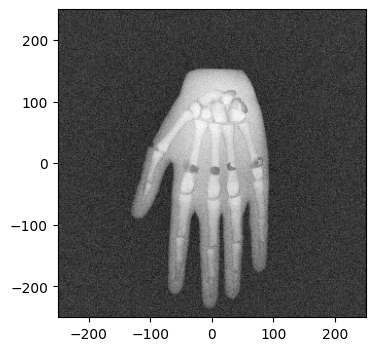

In [14]:
directory = 'build/root/'
csv_name = 'jp1.csv'

x_branch = "X_axis"
y_branch = 'Y_axis'

size = 250
bins = 150

data = dataframe

htmp_array, xlim, ylim = heatmap_array_dask(data, x_branch, y_branch, size, bins)

## Numpy Heatmap Matrix, Normalize

In [14]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def heatmap_array(directory, csv_name, x_branch, y_branch, size, num):
    
    csv_file = os.path.join(directory, csv_name)
    df = pd.read_csv(csv_file)

    x_data = df[x_branch]
    y_data = df[y_branch]

    set_bins = np.arange(-size, size + 1, size/num)
    heatmap, x_edges, y_edges = np.histogram2d(x_data, y_data, bins = [set_bins, set_bins])
    heatmap = heatmap.T
    # print(heatmap.shape)

    row = len(set_bins) // 2
    normal_map = 1 - heatmap / np.max(heatmap)
    plt.plot(normal_map[:][row])
    maxi = np.max(normal_map[:5])
    maxi = maxi * 1.2
    print('altura de ruido:', round(maxi, 4))
    normal_map[normal_map < maxi] = 0

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(normal_map, cmap='gray', extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    plt.subplot(1, 2, 2)
    plt.plot(normal_map[:][row])
    # plt.savefig('Results/circ1_2.jpg', dpi = 300)

    return normal_map, x_edges, y_edges

    # optional: save array as csv
    # np.savetxt("Results/array2.csv", htmp_array, delimiter=",", fmt="%f")
    # print(htmp_array.shape)

In [ ]:
directory = 'build/root/'
csv_name = 'jp1.csv'

x_branch = "X_axis"
y_branch = 'Y_axis'

size = 100
bins = 60

htmp_array, xlim, ylim = heatmap_array(directory, csv_name, x_branch, y_branch, size, bins)

## Eliminate Noise by Fourier Transform

In [22]:
import numpy as np
from scipy.fft import fft2, fftshift, ifft2
import matplotlib.pyplot as plt
from scipy import signal

def Denoise(htmp_array, hann, alpha):

    image = htmp_array

    fft_image = fft2(image)
    fft_image = fftshift(fft_image)

    rows, cols = image.shape

    hann = False
    if hann == True:
    
        l = rows * alpha
        a = np.hanning(l)
        b = np.hanning(l)

        padding_size = rows - len(a)
        left_padding = padding_size // 2
        right_padding = padding_size - left_padding
        a = np.pad(a, (left_padding, right_padding), mode='constant')

        padding_size = cols - len(b)
        left_padding = padding_size // 2
        right_padding = padding_size - left_padding
        b = np.pad(b, (left_padding, right_padding), mode='constant')

        window = np.outer(a, b)

    else:

        a = signal.windows.tukey(rows, alpha)
        b = signal.windows.tukey(rows, alpha)
        window = np.outer(a, b)

    plt.figure(figsize=(10, 2))
    plt.subplot(1, 3, 2)
    plt.plot(a)

    fft_image_2 = fft_image * (window)

    plt.subplot(1, 3, 3)
    plt.plot(np.abs((fft_image_2[:][rows//2])))

    fft_image = fftshift(fft_image_2)
    fft_image = (ifft2(fft_image))
    fft_image = (np.abs(fft_image))

    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Filtered Image')
    plt.imshow(fft_image, cmap='gray')
    plt.savefig('Results/four1.jpg', dpi = 300)
    plt.show()

    print(fft_image.shape)
    plt.plot(fft_image[:][60])

    return fft_image

In [ ]:
hann = False
alpha = .1
# htmp_array = dataframe
fft_image = Denoise(htmp_array, hann, alpha)

## Denoise with Skimage.Denoise_Bilateral

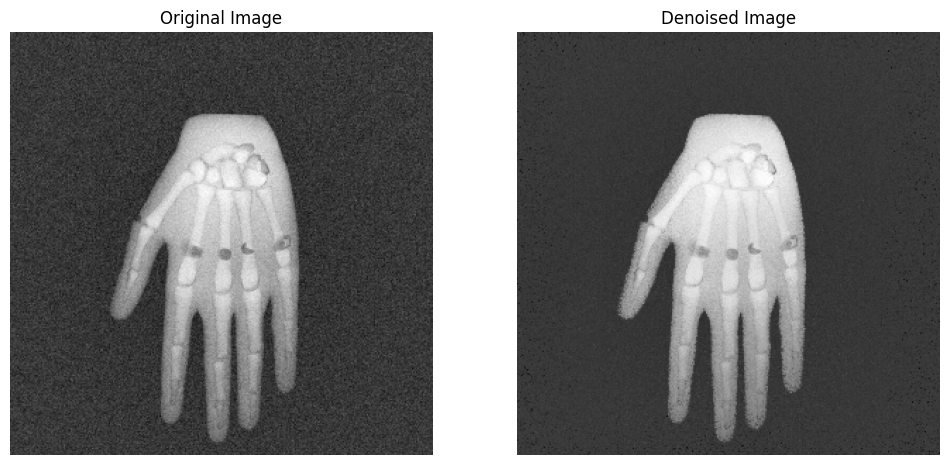

In [20]:
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt

image = htmp_array
denoised_image = denoise_bilateral(image, sigma_color=0.06, sigma_spatial=15, channel_axis=None)

# Display the original and denoised images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(denoised_image, cmap='gray')
ax[1].set_title('Denoised Image')
ax[1].axis('off')

plt.show()

## Save New Heatmap from Numpy Array

In [33]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

def heatmap2(array, xlim, ylim, title, x_label, y_label, width, height, save_as):

    fig = go.Figure(go.Heatmap(
                    z = array,
                    x = xlim,
                    y = ylim,
                    colorscale = [[0, 'black'], [1, 'white']],  # Grayscale from black to white
                    colorbar = dict(title = "Density", tickfont = dict(family = 'Merriweather', size = 16, color = 'Black'))))
    
    font_family = 'Merriweather'
    font_small  = 16
    font_medium = 20
    font_large  = 18
    
    fig.update_layout(
                    title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), 
                                 x = 0.51, y = 0.93, yanchor = 'middle', xanchor = 'center'),
                    xaxis_title = dict(text = x_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    yaxis_title = dict(text = y_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    xaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 25),
                    yaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 10),
                    width  = width,
                    height = height,
                    margin = dict(l = 105, r = 90, t = 90, b = 90)
    )
    
    # pio.write_image(fig, save_as, width = width, height = height, scale = 5)
    fig.show()

In [ ]:
array = fft_image
# array = htmp_array
# array = denoised_image 

title = r"$ \large{ \text{Osteoporosis.}} \ \normalsize{ \text{D to Target} =50cm, \ \text{D to Detector} =15cm, \ \theta = 0°} $"
x_label = r"$ \large{ \text{X Axis} \ (mm)} $"
y_label = r"$ \large{ \text{Y Axis} \ (mm)} $"

width  = 800
height = 800

save_as = 'Results/test.jpg'

heatmap2(array, xlim, ylim, title, x_label, y_label, width, height, save_as)